<a href="https://colab.research.google.com/github/laquine/pos-devai/blob/main/ia_atividade02_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desenvolver um modelo completo para o dataset da competição Titanic do Kaggle: [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/)



## Obtenção dos arquivos e pré-processamento

In [5]:
#extraindo os arquivos do zip e armazenando no Google Drive
!unzip /content/drive/MyDrive/datasets/titanic.zip -d /content/drive/MyDrive/datasets

Archive:  /content/drive/MyDrive/datasets/titanic.zip
  inflating: /content/drive/MyDrive/datasets/gender_submission.csv  
  inflating: /content/drive/MyDrive/datasets/test.csv  
  inflating: /content/drive/MyDrive/datasets/train.csv  


In [41]:
#lendo os dados de treinamento e exibindo os tipos das características
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/datasets/train.csv")
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [42]:
#isolando o target, a coluna que devemos fazer a predição
y = data['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [43]:
#removendo o target do dataset de treinamento
X = data.drop('Survived', axis=1)
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [44]:
#exibindo para cada característica a quantidade de valores distintos e o tipo
for column in X.columns:
  print(f"{column:>12} {len(set(X[column])):4} {X[column].dtypes}")

 PassengerId  891 int64
      Pclass    3 int64
        Name  891 object
         Sex    2 object
         Age  265 float64
       SibSp    7 int64
       Parch    7 int64
      Ticket  681 object
        Fare  248 float64
       Cabin  148 object
    Embarked    4 object


In [45]:
#removendo as características que não serão úteis para o modelo
indesejadas = ['PassengerId', 'Name', 'Ticket', 'Cabin']
Xdrop = X.drop(indesejadas, axis=1)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [46]:
#visualizando as colunas numéricas
Xnum = Xdrop.select_dtypes('number')
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [47]:
#visualizando as colunas numéricas com valores nulos
for column in Xnum.columns:
  print(f"{column:>12} {sum(Xnum[column].isnull())}")

      Pclass 0
         Age 177
       SibSp 0
       Parch 0
        Fare 0


In [48]:
#tratamento dos valores nulos da coluna Age usando a mediana
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
XnumLimpo = imputer.fit_transform(Xnum)
XnumLimpo

array([[ 3.    , 22.    ,  1.    ,  0.    ,  7.25  ],
       [ 1.    , 38.    ,  1.    ,  0.    , 71.2833],
       [ 3.    , 26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [ 3.    , 28.    ,  1.    ,  2.    , 23.45  ],
       [ 1.    , 26.    ,  0.    ,  0.    , 30.    ],
       [ 3.    , 32.    ,  0.    ,  0.    ,  7.75  ]])

In [49]:
#visualizando as colunas categóricas
Xcat = Xdrop.select_dtypes('object')
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [50]:
#visualizando as colunas categóricas com valores nulos
for column in Xcat.columns:
  print(f"{column:>12} {sum(Xcat[column].isnull())}")

         Sex 0
    Embarked 2


In [51]:
#tratamento dos valores nulos da coluna Embarked usando o valor mais frequente
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
XcatLimpo = imputer.fit_transform(Xcat)
XcatLimpo

array([['male', 'S'],
       ['female', 'C'],
       ['female', 'S'],
       ...,
       ['female', 'S'],
       ['male', 'C'],
       ['male', 'Q']], dtype=object)

In [52]:
#representação numérica das características categóricas usando OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
XcatHot = encoder.fit_transform(XcatLimpo)
XcatHot

<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [53]:
XcatHot.toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [54]:
#concatenação das características numéricas e categóricas tratadas
import numpy as np
Xtratado = np.c_[XnumLimpo, XcatHot.toarray()]
Xtratado.shape

(891, 10)

In [55]:
#visualização do dataset tratado
Xtratado

array([[ 3., 22.,  1., ...,  0.,  0.,  1.],
       [ 1., 38.,  1., ...,  1.,  0.,  0.],
       [ 3., 26.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 3., 28.,  1., ...,  0.,  0.,  1.],
       [ 1., 26.,  0., ...,  1.,  0.,  0.],
       [ 3., 32.,  0., ...,  0.,  1.,  0.]])

## Pipeline de pré-processamento

In [56]:
#carregando os dados de treinamento e teste
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/datasets/train.csv')
test = pd.read_csv('/content/drive/MyDrive/datasets/test.csv')
train.columns.isin(test.columns)

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [57]:
#confirmação que a coluna target (Survived) não está no treino e está no teste
train.columns[~train.columns.isin(test.columns)]

Index(['Survived'], dtype='object')

In [58]:
#criação de classe que removerá as características indesejadas para o modeloo
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosDesejados(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasIndesejadas_ = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    return self
  def transform(self, X, y=None):
    return X.drop(self.colunasIndesejadas_, axis=1)

atributosDesejados = AtributosDesejados()
Xdrop = atributosDesejados.fit_transform(X)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [59]:
#criação de classe que retornará dataset com as colunas numéricas
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosNumericos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasNumericas = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasNumericas]

atributosNumericos = AtributosNumericos()
Xnum = atributosNumericos.fit_transform(Xdrop)
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [60]:
#criando pipeline para pré-processamento das características numéricas
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipenum = Pipeline([
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

XnumLimpo = pipenum.fit_transform(Xdrop)
XnumLimpo

array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337,  2.00893337, -0.17626324],
       [-1.56610693, -0.25833709, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.82737724,  0.20276197, -0.4745452 , -0.47367361, -0.49237783]])

In [61]:
#criação de classe que retornará dataset com as colunas categóricas
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasCategoricas = X.select_dtypes(include='object').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasCategoricas]

atributosCategoricos = AtributosCategoricos()
Xcat = atributosCategoricos.fit_transform(Xdrop)
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [62]:
#criando pipeline para pré-processamento das características categóricas
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pipecat = Pipeline([
    ('atributos_categoricos', AtributosCategoricos()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

XcatLimpo = pipecat.fit_transform(Xdrop)
XcatLimpo.toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [63]:
#criando pipeline que concatena as características numéricas e categóorias tratadas
from sklearn.pipeline import FeatureUnion

unecaracteristicas = FeatureUnion([
    ('pipenum', pipenum),
    ('pipecat', pipecat)
])

Xtratado = unecaracteristicas.fit_transform(Xdrop)
Xtratado.toarray()

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

In [64]:
#cria o pipeline de pré-processamento
from sklearn.pipeline import Pipeline

preproc = Pipeline([
    ('atributos_desejados', AtributosDesejados()),
    ('unecaracteristicas', unecaracteristicas)
])

Xtratado = preproc.fit_transform(X)
Xtratado.toarray()

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

## Pipeline completo usando Árvore de Decisão

In [65]:
#cria pipeline completo com pré-processamento e usa o algoritmo de árvore de decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

pipetotal = Pipeline([
    ('preproc', preproc),
    ('arvore', DecisionTreeClassifier())
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.9797979797979798

In [80]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.02173471, 0.01547241, 0.01631498, 0.01525807, 0.01564527]),
  'score_time': array([0.00655413, 0.00630355, 0.0065906 , 0.00640559, 0.00634217]),
  'test_score': array([0.74301676, 0.78089888, 0.79213483, 0.7247191 , 0.80898876])},
 0.7699516665620487)

In [81]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('tree_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle (Árvore de Decisão)

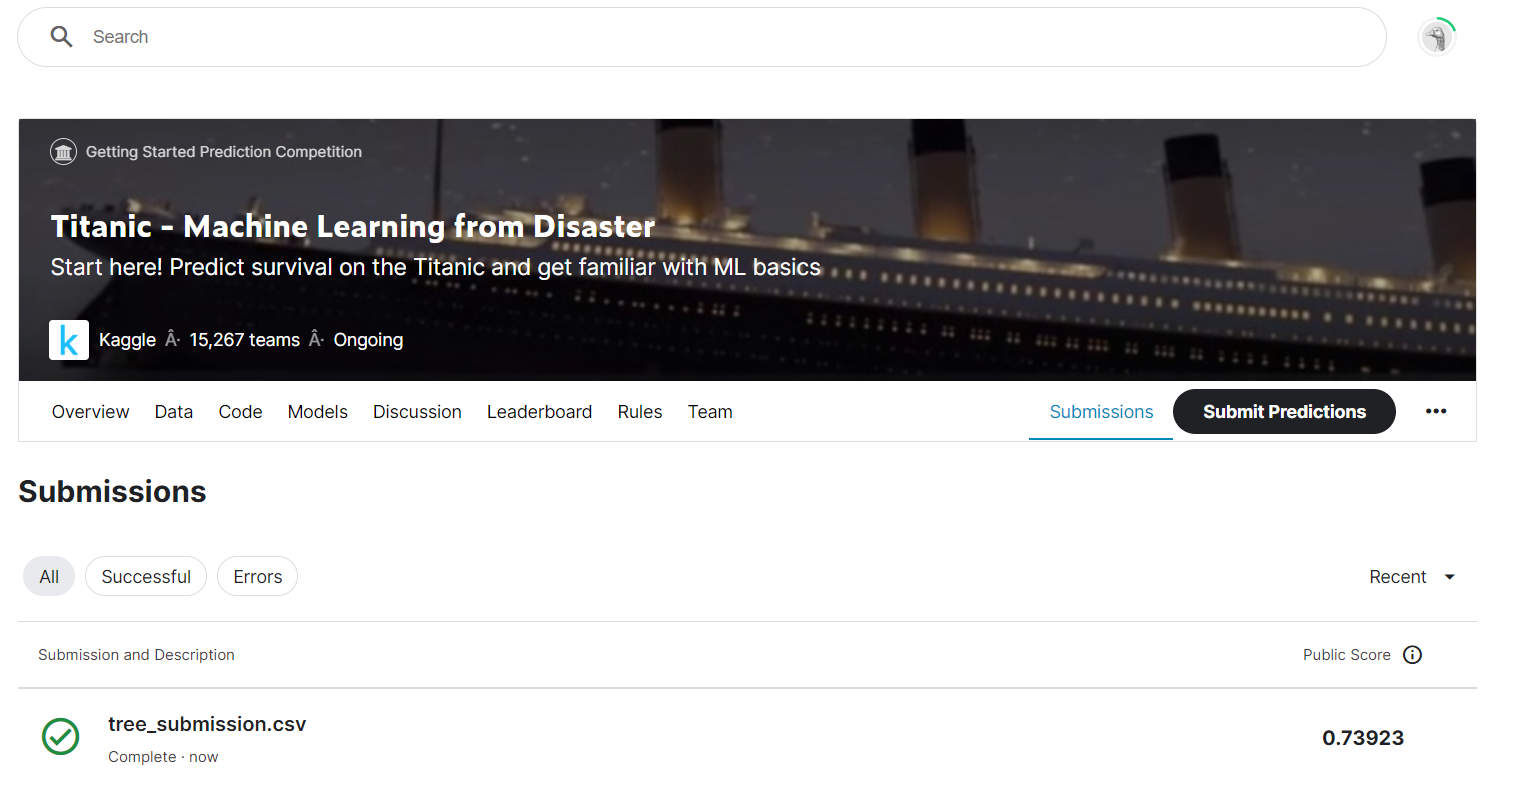

## Usando Grid Search para escolha dos hiperparâmetros

In [82]:
from sklearn.model_selection import GridSearchCV

#testando os parâmetros max_depth do DecisionTreeClassifier
#e diferentes estratégias para tratamento dos valores numéricos nulos
parametros = {
    'arvore__max_depth': [None, 1, 3, 5, 7, 9],
    'preproc__unecaracteristicas__pipenum__imputer__strategy': ['mean', 'median', 'most_frequent']
}

modelo = GridSearchCV(pipetotal, param_grid=parametros)

scores = cross_validate(modelo, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([2.14765811, 2.07472873, 2.09076476, 2.07292604, 2.77210522]),
  'score_time': array([0.00615144, 0.00617743, 0.00631046, 0.00630379, 0.00945544]),
  'test_score': array([0.81564246, 0.81460674, 0.81460674, 0.78089888, 0.85393258])},
 0.8159374803841567)

In [83]:
#visualização do hiperparâmetros escolhidos
modelo.fit(X, y)
modelo.best_estimator_

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('atributos_desejados', AtributosDesejados()),
                                 ('unecaracteristicas',
                                  FeatureUnion(transformer_list=[('pipenum',
                                                                  Pipeline(steps=[('atributos_numericos',
                                                                                   AtributosNumericos()),
                                                                                  ('imputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('scaler',
                                                                                   StandardScaler())])),
                                                                 ('pipecat',
                                                                  Pipeline(steps=[('atributos_categoricos',
                                                                                   AtributosCategoricos()),
                                                                                  ('imputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('encoder',
                                                                                   OneHotEncoder())]))]))])),
                ('arvore', DecisionTreeClassifier(max_depth=9))])

In [40]:
#realiza a predição e cria arquivo para submissão ao kaggle
submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
ypred = modelo.predict(test)
submission['Survived'] = ypred
submission.to_csv('tree_gscv_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle (Grid Search)

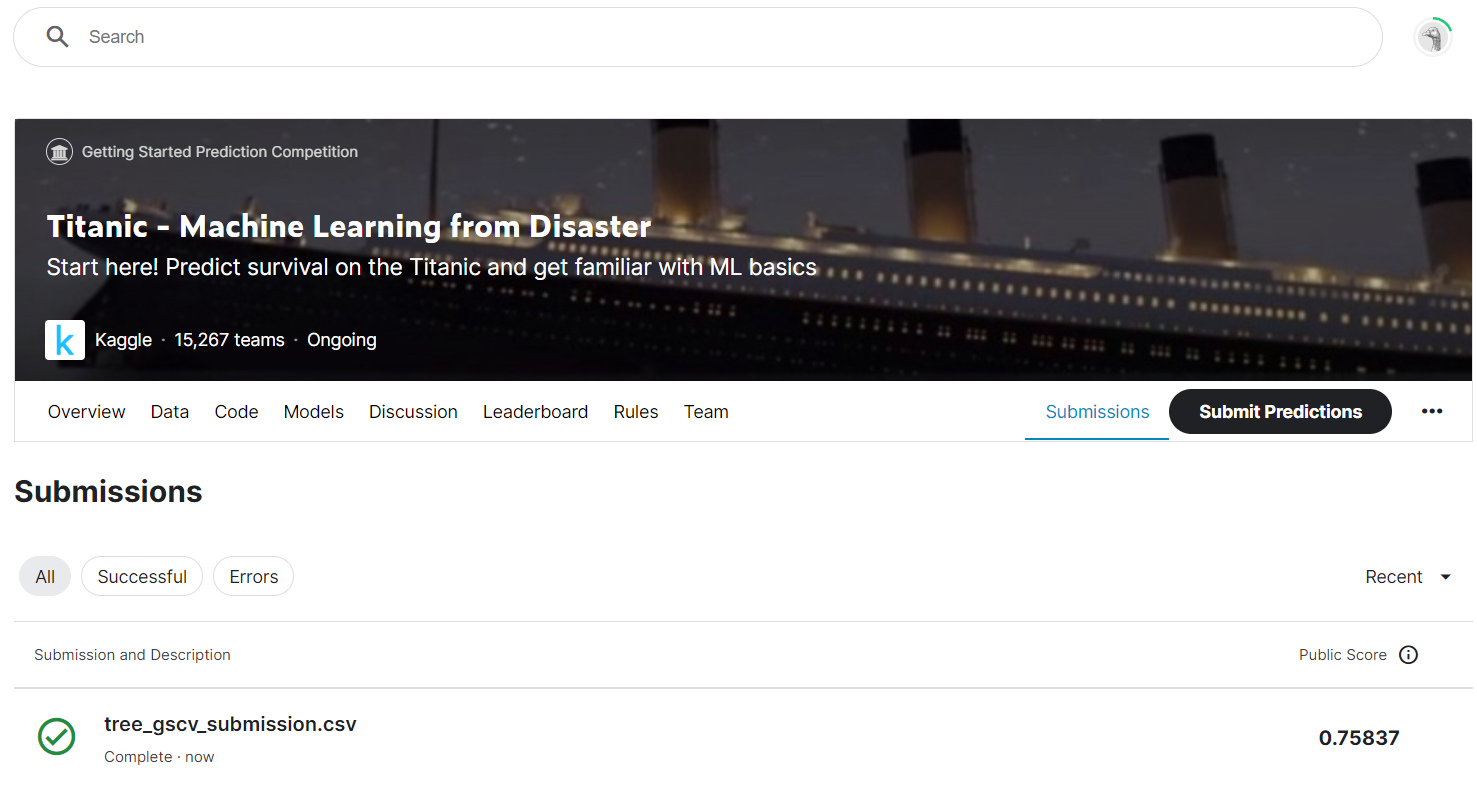

## Pipeline completo usando Random Forest

In [97]:
#cria pipeline completo com pré-processamento e usa o algoritmo Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipetotal = Pipeline([
    ('preproc', preproc),
    ('random_forest', RandomForestClassifier())
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.9797979797979798

In [98]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.3000083 , 0.27871943, 0.29735017, 0.43262696, 0.43809271]),
  'score_time': array([0.01514125, 0.01411581, 0.01570272, 0.0235467 , 0.02106142]),
  'test_score': array([0.78212291, 0.82022472, 0.84831461, 0.78651685, 0.83146067])},
 0.8137279517921036)

In [99]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('random_forest_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle (Random Forest)

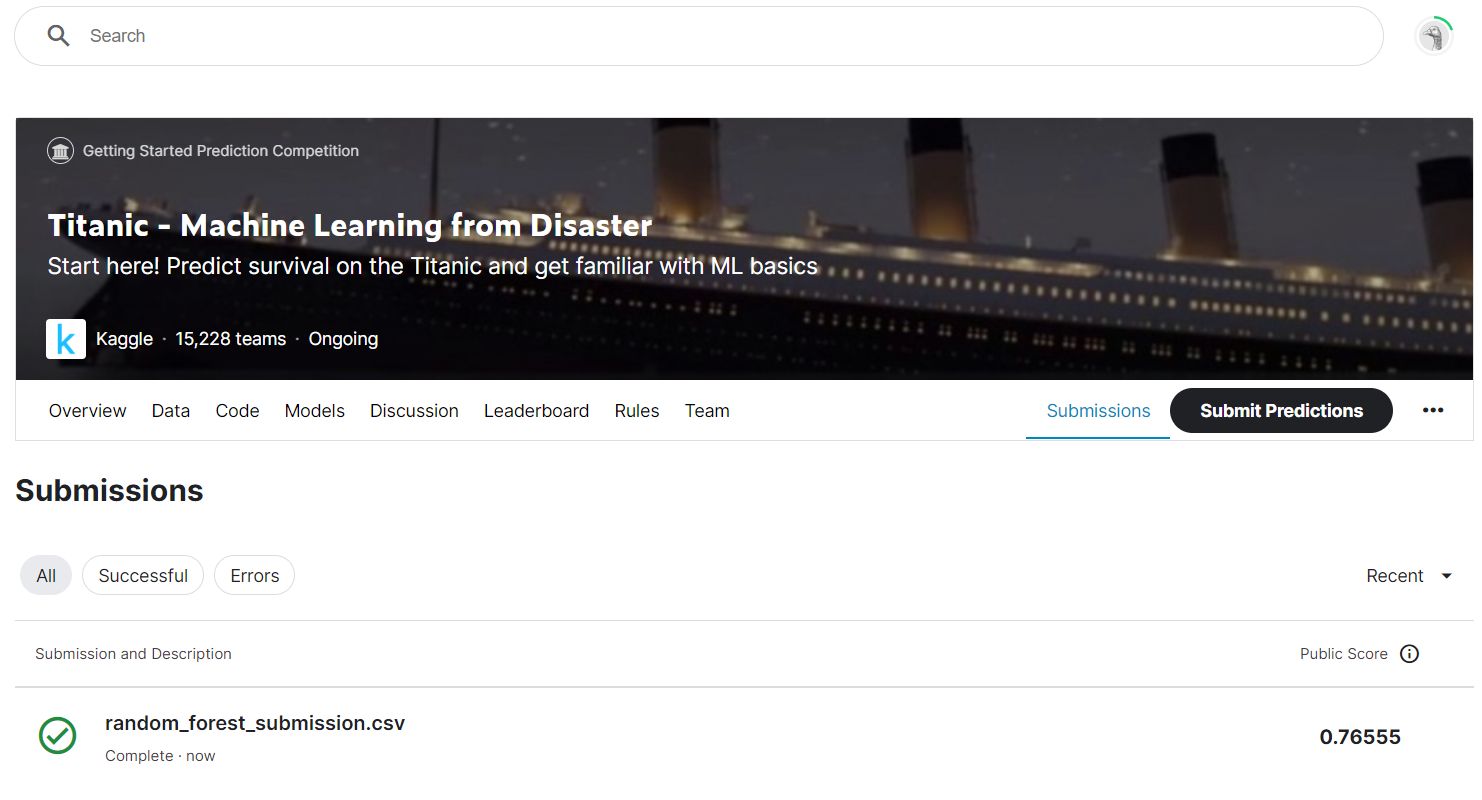

## Pipeline completo usando SVC

In [117]:
#cria pipeline completo com pré-processamento e usa o algoritmo Support Vector Classification
from sklearn import svm
from sklearn.metrics import accuracy_score

pipetotal = Pipeline([
    ('preproc', preproc),
    ('svc', svm.SVC())
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.8383838383838383

In [118]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.03122926, 0.02705622, 0.02847219, 0.0278914 , 0.0280478 ]),
  'score_time': array([0.00915337, 0.00949311, 0.01026368, 0.00905132, 0.00990558]),
  'test_score': array([0.82681564, 0.8258427 , 0.81460674, 0.81460674, 0.85955056])},
 0.8282844768062269)

In [119]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('svc_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle (SVC)

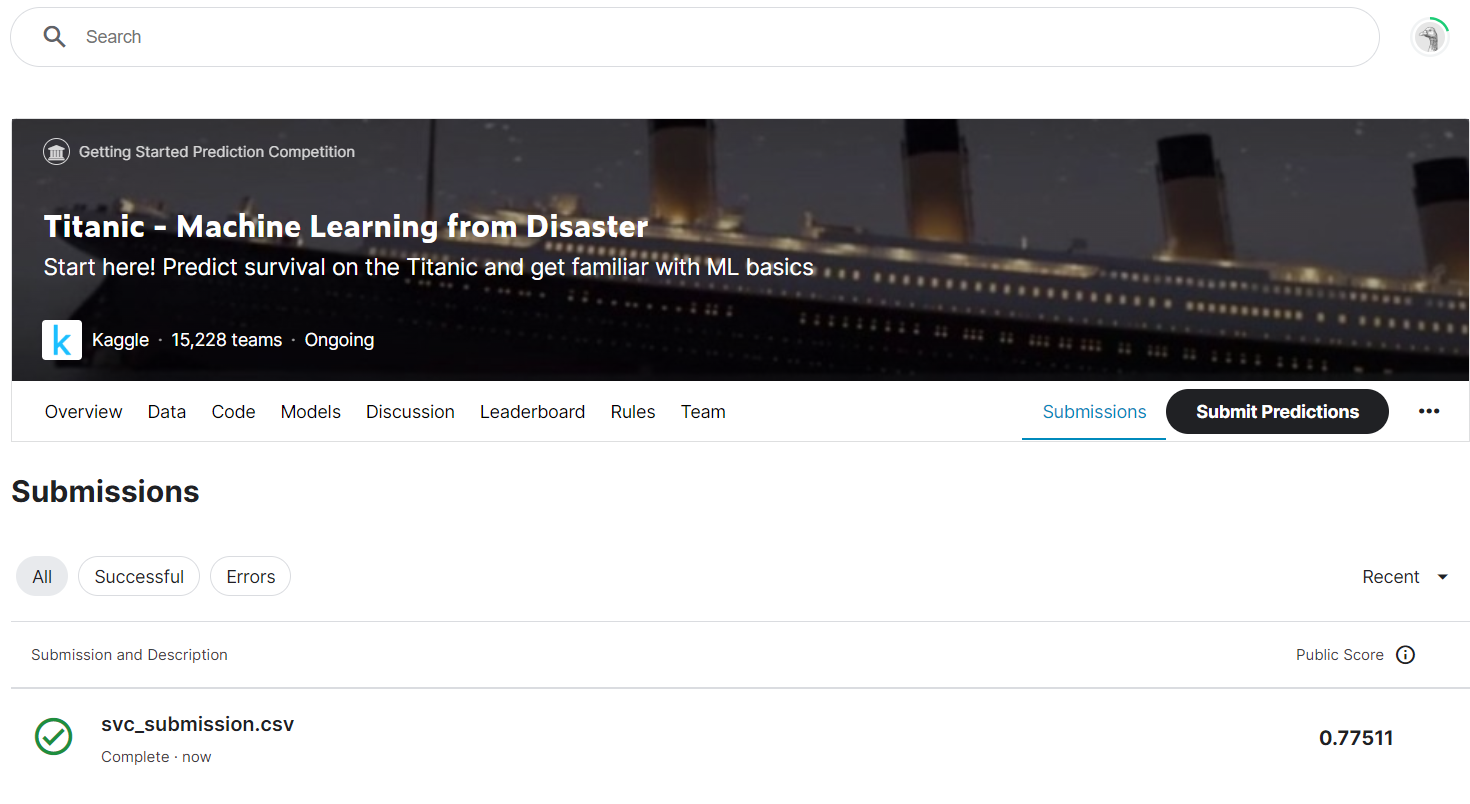

##Submissões ao Kaggle

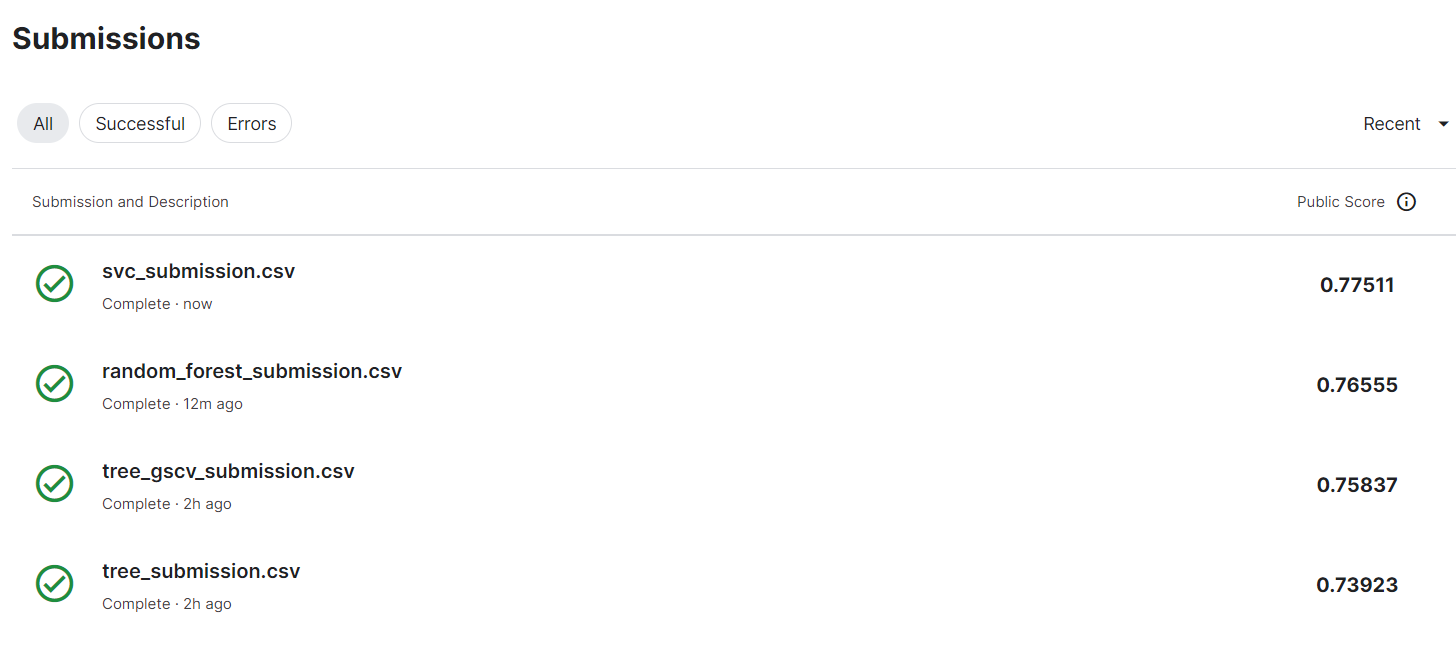